<a href="https://colab.research.google.com/github/YashGabale/IT7103/blob/main/IT7103_Assignment5_YashGabale_ygabale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/real_estate_value.csv')
data.head()
data.info()
data.describe()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HouseAge       414 non-null    float64
 1   DistanceToMRT  414 non-null    float64
 2   NoOfStores     414 non-null    int64  
 3   Latitude       414 non-null    float64
 4   Longitude      414 non-null    float64
 5   UnitPrice      414 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 19.5 KB


,HouseAge,DistanceToMRT,NoOfStores,Latitude,Longitude,UnitPrice
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [ ]:
from sklearn.model_selection import train_test_split

X=data.drop('UnitPrice',axis=1)
Y=data['UnitPrice']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

print(data.shape)
print(X_train.shape)
print(X_test.shape)



(414, 6)
(331, 5)
(83, 5)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data.isnull().sum()

HouseAge         0
DistanceToMRT    0
NoOfStores       0
Latitude         0
Longitude        0
UnitPrice        0
dtype: int64

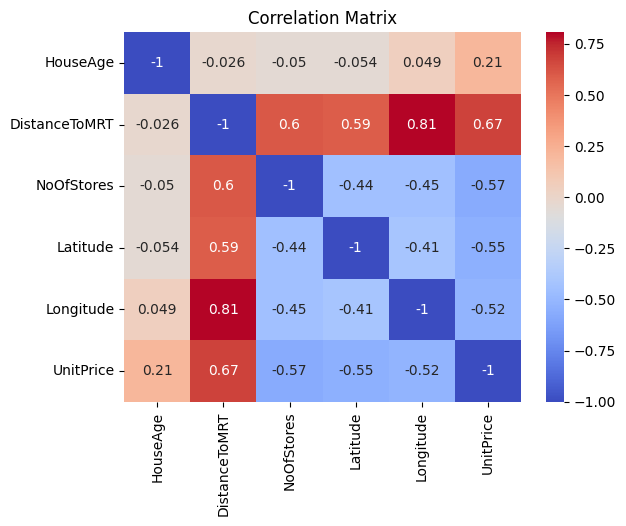

In [ ]:
correaltion_matrix=-data.corr()
sns.heatmap(correaltion_matrix,annot=True,cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Text(0.5, 1.0, 'Distribution of Unit Price')

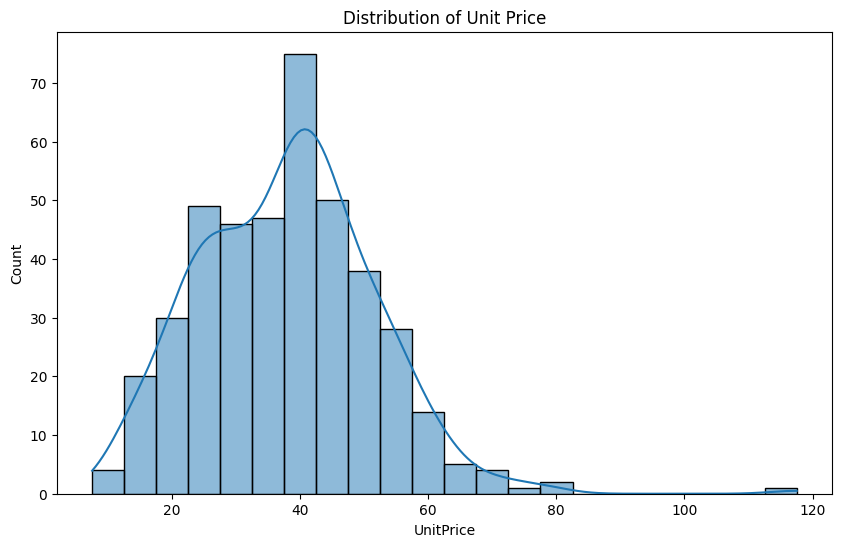

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['UnitPrice'], kde=True)
plt.title('Distribution of Unit Price')


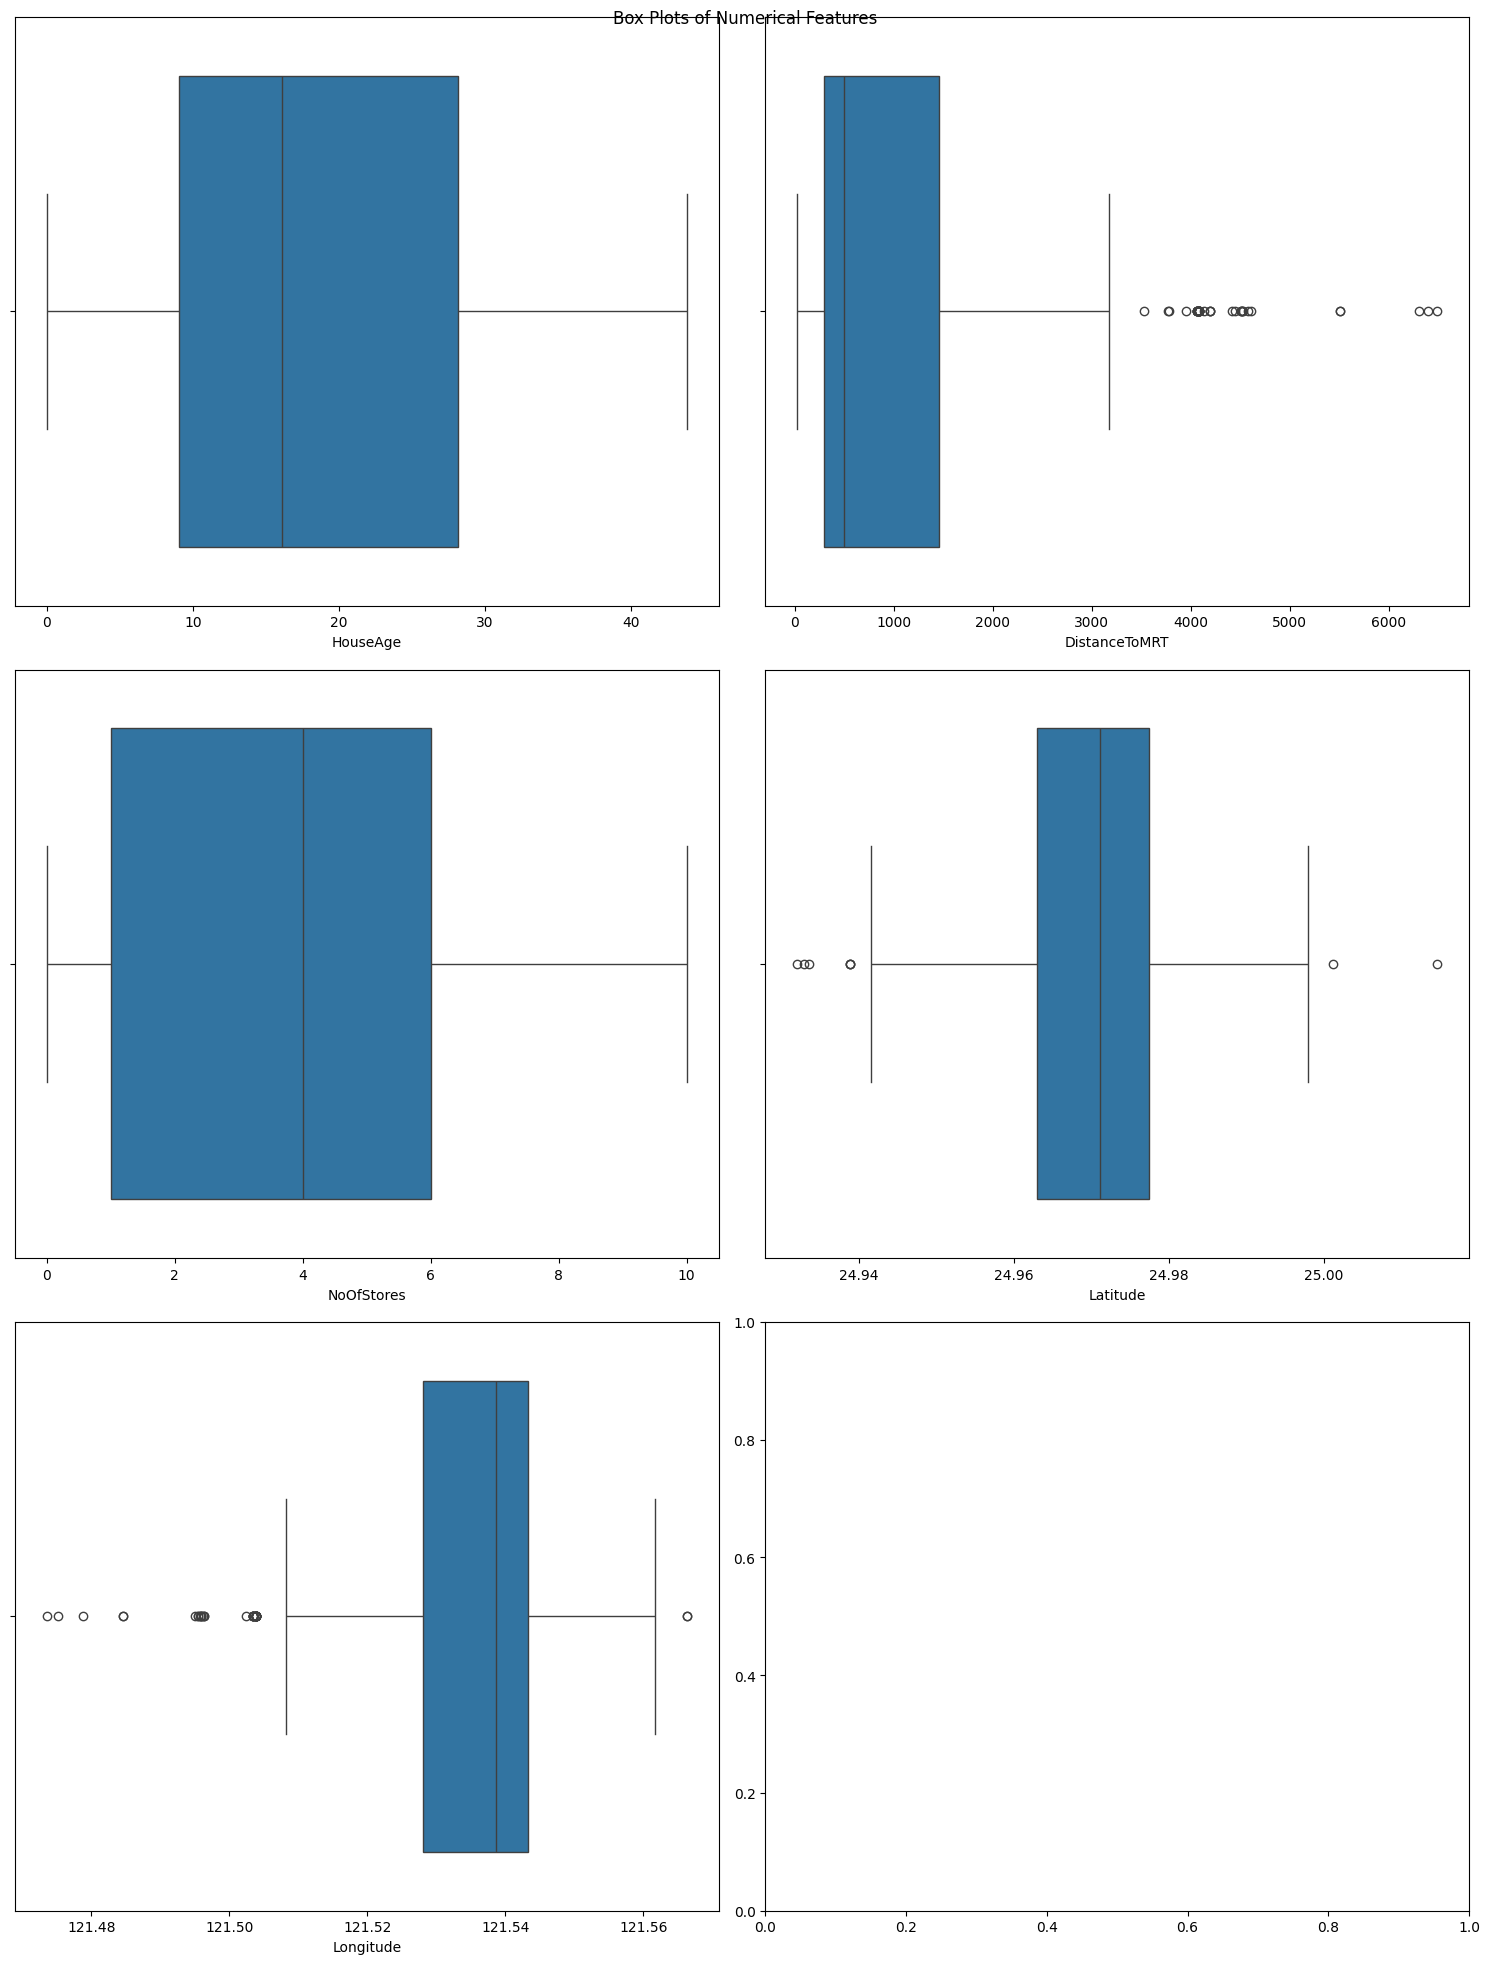

In [ ]:
num_features=['HouseAge','DistanceToMRT','NoOfStores','Latitude','Longitude']
fig,axes=plt.subplots(3,2,figsize=(15,20))
fig.suptitle('Box Plots of Numerical Features')
for i,feature in enumerate(num_features):
  sns.boxplot(x=feature,data=data,ax=axes[i//2,i%2])
plt.tight_layout()

1. No Missing Values are, no imputation needed.
2. Features have different scales, so normalization or standardization is required.
3. Outliners in numerical feature specially in DistanceMRT
4. Wide range in DistanceMRT we can consider Log Transformation.
5. Categorical variables are absent so no encoding is needed.
6. Consider polynomial features for latitude and longitude to capture non linear relationships


In [ ]:
data.drop_duplicates(inplace=True)

#transforming raw data into a more effective set of inputs
data['DistanceTOMRT_log']=np.log(data['DistanceToMRT'])
data['HouseAge_squared']=data['HouseAge']**2

#Seprating feature and target
x=data.drop('UnitPrice',axis=1)
y=data['UnitPrice']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Spliting Data
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#Scaling features
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
#to make better feature handling
X_train_scaled =pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

#DT tuning
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train_scaled, Y_train)

print("Best Decision Tree parameters:", dt_grid.best_params_)
dt_best = dt_grid.best_estimator_

#RF Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_scaled, Y_train)

print("Best Random Forest parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

Best Decision Tree parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

def evaluate_model(model, X_train, Y_train, X_test, Y_test):
    Train_Prediction= model.predict(X_train)
    Test_Prediction=model.predict(X_test)

    print("Train Mean Squared Error:", mean_squared_error(Y_train, Train_Prediction).round(2))
    print("Test Mean Squared Error:", mean_squared_error(Y_test, Test_Prediction).round(2))
    print("Train Root-mean-square Deviation:", np.sqrt(mean_squared_error(Y_train, Train_Prediction)).round(2))
    print("Test Root-mean-square Deviation:", np.sqrt(mean_squared_error(Y_test, Test_Prediction)).round(2))
    print("Train Mean Absolute Error:", mean_absolute_error(Y_train, Train_Prediction).round(2))
    print("Test Mean Absolute Error:", mean_absolute_error(Y_test, Test_Prediction).round(2))
    print("Train R2 Score:", r2_score(Y_train, Train_Prediction).round(2))
    print("Test R2 Score:", r2_score(Y_test, Test_Prediction).round(2))

print("Decision Tree")
evaluate_model(dt_best, X_train_scaled, Y_train, X_test_scaled, Y_test)

print("\nRandom Forest")
evaluate_model(rf_best, X_train_scaled, Y_train, X_test_scaled, Y_test)


Decision Tree
Train Mean Squared Error: 28.46
Test Mean Squared Error: 46.52
Train Root-mean-square Deviation: 5.33
Test Root-mean-square Deviation: 6.82
Train Mean Absolute Error: 3.28
Test Mean Absolute Error: 4.88
Train R2 Score: 0.85
Test R2 Score: 0.72

Random Forest
Train Mean Squared Error: 34.45
Test Mean Squared Error: 32.79
Train Root-mean-square Deviation: 5.87
Test Root-mean-square Deviation: 5.73
Train Mean Absolute Error: 3.7
Test Mean Absolute Error: 3.9
Train R2 Score: 0.82
Test R2 Score: 0.8


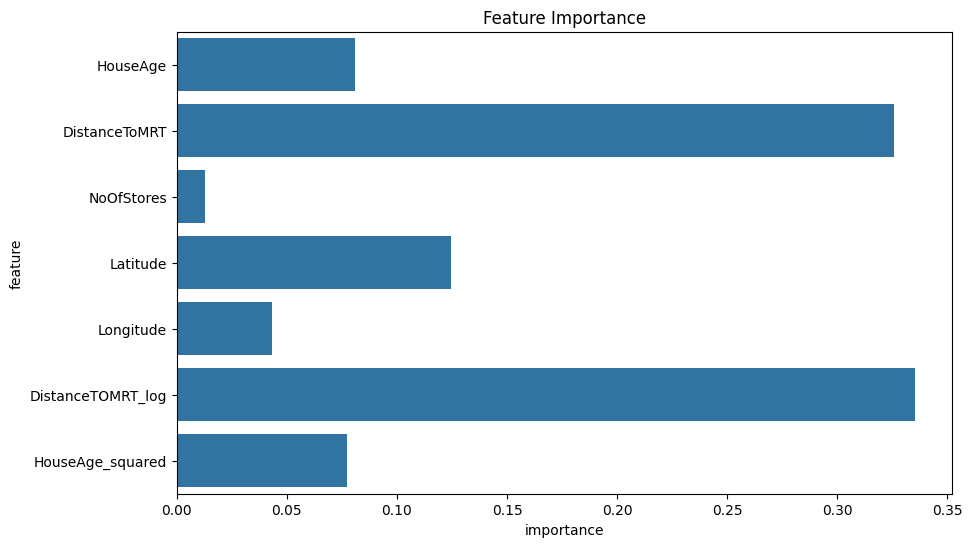

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='importance',y='feature',data=pd.DataFrame({'feature':X_train.columns,'importance':rf_best.feature_importances_}))
plt.title('Feature Importance')
plt.show()

In [ ]:
selector = SelectFromModel(rf_best, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Reshape the data if a single feature was selected
if X_train_selected.ndim == 1:
    X_train_selected = X_train_selected.reshape(-1, 1)  # Reshape to a column vector
if X_test_selected.ndim == 1:
    X_test_selected = X_test_selected.reshape(-1, 1)  # Reshape to a column vector

rf_selected = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
rf_selected.fit(X_train_selected, Y_train)

print("\nRandom Forest Performance with Selected Features:")
evaluate_model(rf_selected, X_train_selected, Y_train, X_test_selected, Y_test) # Order of arguments was incorrect

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Random Forest Performance with Selected Features:
Train Mean Squared Error: 49.89
Test Mean Squared Error: 48.33
Train Root-mean-square Deviation: 7.06
Test Root-mean-square Deviation: 6.95
Train Mean Absolute Error: 4.78
Test Mean Absolute Error: 4.98
Train R2 Score: 0.73
Test R2 Score: 0.71
